# Glass Classification

## Import stuff

In [2]:
import numpy as np
# print(np.__version__)

from IPython import display
import time

import pandas as pd


import matplotlib.pyplot as plt

##----- Use sklearn for some convenience functions-----
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


##----- Import functions from CrysX-NN --------
from crysx_nn.network import visualize
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import errorFunc
from crysx_nn.network import errorFuncGrad
from crysx_nn.network import Softmax
from crysx_nn.network import binary_cross_entropy, binary_cross_entropy_grad
from crysx_nn.network import cross_entropy, cross_entropy_grad

# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed


from tqdm.notebook import tqdm


##------ Import tensorflow ---------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.python.eager import context

##------ Import pytorch and torchvision ---------
import torch, torchvision
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/crysx_nn/network.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Check if NumPy is linked with MKL or not

In [3]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include

## Start with the common stuff

Use learning rate (eta) =0.007 for ReLU  and 0.1 for Sigmoid

In [338]:
nInputs = 9 # There would be 9 features that we would be using
nOutputs = 1
neurons_per_layer = [400,400,6]#
# activation_func_names = ['ReLU','ReLU', 'Softmax']# Use smaller learning rates with ReLU
activation_func_names = ['Sigmoid','Sigmoid','Softmax']# Use larger learning rates with Sigmoid
nLayers = len(neurons_per_layer)
# eeta = 0.007# for ReLU
eeta = 0.1# for Sigmoid
nEpochs=15000
batchSize = 164#164#nSamples
totSamples = 0


#### Activation function dictionary for all the frameworks

In [339]:
act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}

## Visualize 

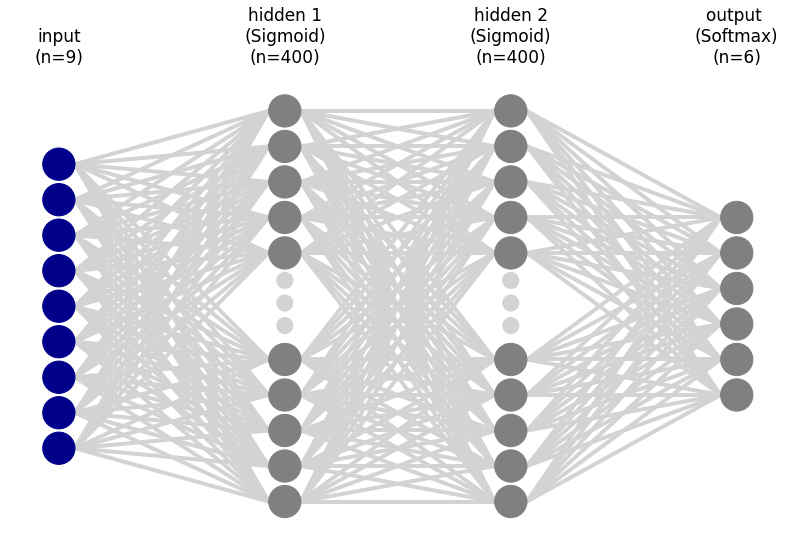

In [340]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Data
This is a Glass Identification Data Set from UCI. It contains 10 attributes including id. The response is glass type(discrete 7 values)

Id number: 1 to 214 

RI: refractive index

Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)

Mg: Magnesium

Al: Aluminum

Si: Silicon

K: Potassium

Ca: Calcium

Ba: Barium

Fe: Iron

Type of glass: (class attribute) -- 1 buildingwindowsfloatprocessed -- 2 buildingwindowsnonfloatprocessed -- 3 vehiclewindowsfloatprocessed -- 4 vehiclewindowsnonfloatprocessed (none in this database) -- 5 containers -- 6 tableware -- 7 headlamps

## Set inputs
Use all the input features

In [341]:
df = pd.read_csv('glass.data.csv',names=['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type'])
df

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


## We can drop the Id column

In [342]:
df = df.drop('Id',1)
df

/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [343]:
print('Number of Null Values: ',df.isnull().sum().sum())

Number of Null Values:  0


## Data Analysis

In [344]:
df['Type'] = df['Type'].astype('category')
print(df.dtypes)
df.describe()

RI       float64
Na       float64
Mg       float64
Al       float64
Si       float64
K        float64
Ca       float64
Ba       float64
Fe       float64
Type    category
dtype: object


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


## Set the inputs and outputs

In [345]:
inputs = df.iloc[:,0:9].to_numpy()
print(inputs)

[[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]


In [346]:
outputs_temp = df.iloc[:,9].to_numpy()
print(outputs_temp)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


The above is just a list/1D array of the output labels/targets. But cysx_nn expects 2d arrays. Furthemore, we also need to one-hot enocde these values, i.e., transform from integer to a set of probabilities.

Reference:
https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

There are many ways to do this but we will use `pd.get_dummies(array)`, because our targets are not consecutive, i.e., there is no type 4 in the data.

and `pandas` handles it quite well.

In [347]:
outputs_df  = pd.get_dummies(outputs_temp) # Get 1 hot-encodes df object
outputs = outputs_df.to_numpy() # Convert df to numpy array
print(outputs)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


## Set float32 precision

In [348]:
inputs = inputs.astype('float32')
outputs = outputs.astype('float32')
print(inputs.dtype)
print(outputs.dtype)

float32
float32


## Split train and test set
We will use sklearn for this

In [349]:
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size = 0.23, random_state = 7)

print(inputs_train.shape)


(164, 9)


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [350]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [351]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 400)               4000      
_________________________________________________________________
dense_40 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 2406      
Total params: 166,806
Trainable params: 166,806
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [352]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.01218601  0.1123827   0.09636922 ... -0.08194507  0.0312873
   0.0638085 ]
 [ 0.07020019  0.05520828 -0.0864361  ...  0.00309852 -0.03668259
   0.08010086]
 [-0.09506121 -0.02504367  0.08986604 ...  0.11878516 -0.02681704
  -0.08396655]
 ...
 [ 0.02321531 -0.00241978  0.02813889 ...  0.03111927 -0.10070007
   0.00987057]
 [-0.09591807 -0.09340075  0.1051909  ... -0.10031658 -0.01874397
  -0.01510967]
 [ 0.06026354 -0.10918371  0.11265385 ... -0.10028113  0.10115148
   0.10621056]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

## Save the weights generated by tf.keras and use them for our implementation as well

In [353]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[-0.01218601,  0.07020019, -0.09506121, ...,  0.02321531,
        -0.09591807,  0.06026354],
       [ 0.1123827 ,  0.05520828, -0.02504367, ..., -0.00241978,
        -0.09340075, -0.10918371],
       [ 0.09636922, -0.0864361 ,  0.08986604, ...,  0.02813889,
         0.1051909 ,  0.11265385],
       ...,
       [-0.08194507,  0.00309852,  0.11878516, ...,  0.03111927,
        -0.10031658, -0.10028113],
       [ 0.0312873 , -0.03668259, -0.02681704, ..., -0.10070007,
        -0.01874397,  0.10115148],
       [ 0.0638085 ,  0.08010086, -0.08396655, ...,  0.00987057,
        -0.01510967,  0.10621056]], dtype=float32), array([[-0.04193047, -0.08225264, -0.00652236, ..., -0.06437135,
         0.01997335, -0.06459503],
       [ 0.04691359, -0.08322369, -0.06620493, ..., -0.07463606,
        -0.05090952,  0.03039134],
       [-0.00868831,  0.0020301 , -0.0546881 , ..., -0.04187179,
         0.01585591,  0.07142913],
       ...,
       [-0.07261309, -0.0724858 , -0.07

## Compile model

In [354]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
# model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['binary_crossentropy'])
# model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['categorical_crossentropy'])



## Forward feed

In [355]:
model.evaluate(inputs_train, outputs_train, batch_size=batchSize)

164/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.42317697405815125, 0.42317697]

## Does tf.model.evaluate change the weights and biases?

In [356]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.01218601  0.1123827   0.09636922 ... -0.08194507  0.0312873
   0.0638085 ]
 [ 0.07020019  0.05520828 -0.0864361  ...  0.00309852 -0.03668259
   0.08010086]
 [-0.09506121 -0.02504367  0.08986604 ...  0.11878516 -0.02681704
  -0.08396655]
 ...
 [ 0.02321531 -0.00241978  0.02813889 ...  0.03111927 -0.10070007
   0.00987057]
 [-0.09591807 -0.09340075  0.1051909  ... -0.10031658 -0.01874397
  -0.01510967]
 [ 0.06026354 -0.10918371  0.11265385 ... -0.10028113  0.10115148
   0.10621056]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [357]:
# fit the keras model on the dataset
model.fit(inputs_train, outputs_train, epochs=1, batch_size=batchSize)

Train on 164 samples
164/164 [==============================] - 1s 3ms/sample - loss: 0.4232 - binary_crossentropy: 0.4232


## Now the weights and biases must have been updated

In [358]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.01219144  0.11238267  0.09637006 ... -0.08194508  0.03128629
   0.06380623]
 [ 0.07015102  0.05520818 -0.08642902 ...  0.00309844 -0.03669024
   0.08008152]
 [-0.09506411 -0.02504394  0.08986799 ...  0.11878513 -0.02682471
  -0.08396941]
 ...
 [ 0.02318002 -0.00241993  0.02814404 ...  0.03111923 -0.10070538
   0.00985583]
 [-0.09591991 -0.09340066  0.10519081 ... -0.10031658 -0.01874297
  -0.01510978]
 [ 0.06026323 -0.10918372  0.11265392 ... -0.10028113  0.10115141
   0.10621038]]

 Biases for layer  1
[-3.57850513e-06 -1.27671456e-08  5.54448206e-07  9.12852272e-07
  4.04973161e-06  8.09552603e-07  1.82741488e-07 -1.81248888e-05
  2.72117791e-06  1.24665519e-07  3.75604046e-08  1.42622227e-07
 -1.02689944e-06  1.33107134e-08 -8.70564509e-06  8.90571755e-06
 -1.24023354e-05 -1.58364358e-07 -6.88091528e-10  2.85037601e-07
 -3.36443304e-06  2.37363533e-08 -4.18888302e-09  5.84878030e-08
  6.30184218e-07 -1.20708319e-06 -4.28741593e-08  1.93732249e-05
  4.5554

## Now let us do a forward feed again and calculate the loss/error

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [359]:
out = model.evaluate(inputs_train, outputs_train, batch_size=batchSize)
print(out)

164/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for multiple epochs

Note: Batch size=164 indicates that we are using all the training data(examples).

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [360]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=batchSizenSamples, verbose=0)
history = model.fit(inputs_train, outputs_train, epochs=nEpochs, batch_size=batchSize, verbose=0)

CPU times: user 6min 24s, sys: 7min 41s, total: 14min 5s
Wall time: 2min 6s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [361]:
history.history

{'loss': [0.4044407308101654,
  0.40062281489372253,
  0.3993977904319763,
  0.39888662099838257,
  0.3986307382583618,
  0.39848777651786804,
  0.3984019458293915,
  0.39834728837013245,
  0.39831045269966125,
  0.39828401803970337,
  0.3982638418674469,
  0.3982475697994232,
  0.3982335925102234,
  0.3982212245464325,
  0.3982098698616028,
  0.3981992304325104,
  0.39818906784057617,
  0.39817920327186584,
  0.39816972613334656,
  0.39816033840179443,
  0.398151159286499,
  0.398142009973526,
  0.3981330096721649,
  0.398124098777771,
  0.39811521768569946,
  0.3981063663959503,
  0.39809757471084595,
  0.3980887830257416,
  0.39808008074760437,
  0.39807143807411194,
  0.39806267619132996,
  0.3980540633201599,
  0.3980454206466675,
  0.39803680777549744,
  0.39802825450897217,
  0.3980197012424469,
  0.39801114797592163,
  0.39800262451171875,
  0.39799410104751587,
  0.39798563718795776,
  0.39797714352607727,
  0.39796870946884155,
  0.3979603052139282,
  0.3979518711566925,
  0.

## Now also let us have a look at the predictions for the sake of the tutorial

In [362]:
# make probability predictions with the model
predictionsTensorflow = model.predict(inputs_test)
print(predictionsTensorflow) # Probabilities

predictions_max_int = (predictionsTensorflow == predictionsTensorflow.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[4.92530316e-01 3.16076338e-01 1.48464292e-01 3.94797372e-03
  2.40250621e-02 1.49559220e-02]
 [6.79898798e-01 1.26177326e-01 1.57551825e-01 6.19539467e-04
  3.04977465e-02 5.25474781e-03]
 [5.63255250e-01 2.17281893e-01 1.61002576e-01 2.27411441e-03
  4.23177369e-02 1.38683803e-02]
 [6.51662767e-01 1.87682137e-01 1.44422397e-01 1.13430386e-03
  1.14187915e-02 3.67955328e-03]
 [7.22724795e-01 9.50752497e-02 1.53874665e-01 2.82240188e-04
  2.47381907e-02 3.30487126e-03]
 [6.17229342e-01 1.85818210e-01 1.56394213e-01 1.55811128e-03
  3.02881841e-02 8.71196017e-03]
 [6.45261645e-01 1.96019560e-01 1.38900757e-01 1.71632413e-03
  1.34812063e-02 4.62042587e-03]
 [6.44663453e-01 1.94082007e-01 1.45282850e-01 1.13541936e-03
  1.10233482e-02 3.81296827e-03]
 [4.36040908e-01 2.97270030e-01 1.59994394e-01 3.97378206e-03
  6.58322275e-02 3.68886553e-02]
 [5.44673383e-01 2.41978183e-01 1.62332892e-01 2.14007148e-03
  3.41364853e-02 1.47389639e-02]
 [5.91318369e-01 1.97437674e-01 1.63374275e-01 1.4

# Accuracy , Confusion matrix, Classification Report

In [363]:
# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[13,  0,  0,  0,  0,  0],
       [20,  1,  0,  1,  2,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  6]])

In [364]:
# We need to use argmax as one hot encodings are not supported by accuracy_score
accuracy_score(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

0.4

In [365]:
# We need to use argmax as one hot encodings are not supported by classification_report
classification_report(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

'              precision    recall  f1-score   support\n\n           0       0.36      1.00      0.53        13\n           1       0.33      0.04      0.07        24\n           2       0.00      0.00      0.00         3\n           3       0.00      0.00      0.00         3\n           4       0.00      0.00      0.00         1\n           5       0.86      1.00      0.92         6\n\n    accuracy                           0.40        50\n   macro avg       0.26      0.34      0.25        50\nweighted avg       0.36      0.40      0.28        50\n'

## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [366]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_39_input:0", shape=(None, 9), dtype=float32)

 Outputs for layer  1
Tensor("dense_39/Identity:0", shape=(None, 400), dtype=float32)

 Inputs for layer  2
Tensor("dense_39/Identity:0", shape=(None, 400), dtype=float32)

 Outputs for layer  2
Tensor("dense_40/Identity:0", shape=(None, 400), dtype=float32)

 Inputs for layer  3
Tensor("dense_40/Identity:0", shape=(None, 400), dtype=float32)

 Outputs for layer  3
Tensor("dense_41/Identity:0", shape=(None, 6), dtype=float32)


In [367]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_39_input:0", shape=(None, 9), dtype=float32)

 Outputs for layer  1
Tensor("dense_39/Identity:0", shape=(None, 400), dtype=float32)

 Inputs for layer  2
Tensor("dense_39/Identity:0", shape=(None, 400), dtype=float32)

 Outputs for layer  2
Tensor("dense_40/Identity:0", shape=(None, 400), dtype=float32)

 Inputs for layer  3
Tensor("dense_40/Identity:0", shape=(None, 400), dtype=float32)

 Outputs for layer  3
Tensor("dense_41/Identity:0", shape=(None, 6), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [368]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]

 Outputs for layer  1
[[2.82078981e-03 9.97389793e-01 5.43695748e-01 ... 3.05086374e-04
  1.03242546e-01 2.07778811e-03]
 [2.96181440e-03 9.97718096e-01 5.09198070e-01 ... 2.31742859e-04
  1.61324292e-01 2.09978223e-03]
 [2.82385945e-03 9.97715473e-01 5.14910400e-01 ... 2.20537186e-04
  1.73025310e-01 1.98081136e-03]
 ...
 [3.30016017e-03 9.97727811e-01 3.70624959e-01 ... 1.16616488e-04
  2.59269148e-01 2.58055329e-03]
 [3.26535106e-03 9.97771084e-01 3.68582785e-01 ... 1.15543604e-04
  2.52289295e-01 2.54425406e-03]
 [3.29619646e-03 9.97695208e-01 3.77786636e-01 ... 1.17361546e-04
  2.54046798e-01 

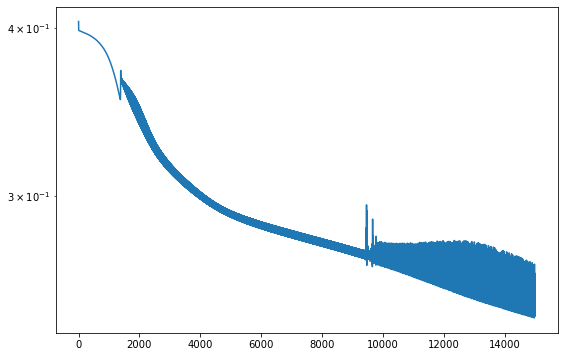

In [369]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [34]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_train, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', BCE_loss(a[nLayers],outputs_train)/batchSize)

Outputs at each layer (including input layer):
  [array([[1.51793e+00, 1.27900e+01, 3.50000e+00, ..., 8.77000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51900e+00, 1.34900e+01, 3.48000e+00, ..., 9.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51832e+00, 1.33300e+01, 3.34000e+00, ..., 8.99000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51764e+00, 1.29800e+01, 3.54000e+00, ..., 8.53000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51556e+00, 1.38700e+01, 0.00000e+00, ..., 9.41000e+00,
        8.10000e-01, 1.00000e-02],
       [1.52119e+00, 1.29700e+01, 3.30000e-01, ..., 1.12700e+01,
        0.00000e+00, 2.80000e-01]], dtype=float32), array([[ 7.6194787 ,  0.        ,  5.474998  , ...,  1.78046966,
         9.29776859, 14.15004158],
       [ 7.59556913,  0.        ,  5.40860081, ...,  1.62338424,
         9.08863354, 14.07444096],
       [ 7.67481279,  0.        ,  5.44205284, ...,  1.65170956,
         9.17779922, 14.12035847],
       ...,
       [ 

Error:
 1.2623581357943046


## Backpropagation

In [35]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = BCE_loss_grad(a[nLayers], outputs_train)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[-1.52630953e-03  1.01635696e-03  1.01626106e-03  1.52592556e-03
   1.01632122e-03  1.01627168e-03]
 [-1.52580560e-03  1.01637343e-03  1.01626115e-03  1.52537598e-03
   1.01632274e-03  1.01627399e-03]
 [ 3.02452480e-03  1.01636863e-03 -1.07572489e+03  1.53011307e-03
   1.01632057e-03  1.01627306e-03]
 [-1.54679786e-03  1.01635334e-03  1.01626100e-03  1.54641563e-03
   1.01632018e-03  1.01627118e-03]
 [ 3.97803216e-03  1.01633804e-03  1.01626136e-03 -3.98002291e-03
   1.01630296e-03  1.01626816e-03]
 [ 4.73494368e-03 -8.89775309e+00  1.01626180e-03  1.29371875e-03
   1.01629789e-03  1.01627130e-03]
 [-1.57758306e-03  1.01635478e-03  1.01626105e-03  1.57718134e-03
   1.01632029e-03  1.01627129e-03]
 [-1.58362807e-03  1.01635258e-03  1.01626100e-03  1.58322822e-03
   1.01632074e-03  1.01627105e-03]
 [ 3.52730395e-03 -7.96264117e+00  1.01626132e-03  1.42718831e-03
   1.01630439e-03  1.01627204e-03]
 [ 2.810327

Gradient of Cost (error function) wrt weights:
 [array([[ 7.02294102e-03,  5.90147898e-02,  6.58369111e-03,
         7.97039270e-03,  3.35040957e-01,  4.07934189e-03,
         4.92563657e-02, -1.12341042e-03,  3.78249271e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.11656776e-02,  9.87042785e-02,  8.00083578e-03,
         1.41959460e-02,  5.32986820e-01,  5.82166528e-03,
         7.14302883e-02,  2.44516903e-03,  4.96289926e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.32513663e-03, -1.06514199e-02,  0.00000000e+00,
        -9.68991080e-04, -6.25124872e-02, -1.84615521e-04,
        -1.23135140e-02,  0.00000000e+00, -8.15724852e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

## Gradient descent (update the weights and biases)

In [36]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 1.98544204e-01, -4.69059348e-02, -1.28484234e-01,
         2.09803805e-01,  8.16575512e-02,  3.69007103e-02,
         2.24147797e-01,  1.93973109e-01, -1.91882953e-01],
       [ 2.30302319e-01,  1.15634069e-01, -1.96352944e-01,
         4.37889844e-02, -9.02411044e-02, -1.95118189e-02,
        -1.23023175e-01,  6.64819628e-02,  7.92592913e-02],
       [ 2.97651850e-02, -1.31251290e-01,  2.18919203e-01,
         1.81011915e-01,  5.30930758e-02,  2.69380249e-02,
         2.23352283e-01, -1.50095046e-01, -1.23477192e-03],
       [ 2.03754082e-01,  4.09916788e-02,  9.36537236e-02,
        -9.97603685e-02, -6.72588795e-02, -1.94756433e-01,
        -1.10193372e-01, -2.33362466e-02,  1.06282339e-01],
       [-2.40864977e-02, -8.91111717e-02, -9.12487656e-02,
        -1.57294236e-02, -1.97148770e-02, -1.52073592e-01,
         2.30724409e-01, -7.08919615e-02, -5.03043365e-03],
       [-1.48038566e-03, -2.80580968e-02, -1.05831206e-01,
         5.37289679e-03, -1.25341386

## Forward feed again and check the loss/error

In [37]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_train, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', BCE_loss(a[nLayers],outputs_train)/batchSize)

Outputs at each layer (including input layer):
  [array([[1.51793e+00, 1.27900e+01, 3.50000e+00, ..., 8.77000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51900e+00, 1.34900e+01, 3.48000e+00, ..., 9.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51832e+00, 1.33300e+01, 3.34000e+00, ..., 8.99000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51764e+00, 1.29800e+01, 3.54000e+00, ..., 8.53000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51556e+00, 1.38700e+01, 0.00000e+00, ..., 9.41000e+00,
        8.10000e-01, 1.00000e-02],
       [1.52119e+00, 1.29700e+01, 3.30000e-01, ..., 1.12700e+01,
        0.00000e+00, 2.80000e-01]], dtype=float32), array([[ 7.6194787 ,  0.        ,  5.474998  , ...,  1.78046966,
         9.29776859, 14.15004158],
       [ 7.59556913,  0.        ,  5.40860081, ...,  1.62338424,
         9.08863354, 14.07444096],
       [ 7.67481279,  0.        ,  5.44205284, ...,  1.65170956,
         9.17779922, 14.12035847],
       ...,
       [ 

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [38]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs_train, outputs_train, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=1,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/100 [00:00<?, ?it/s]

Average Error with initial weights and biases: 1.2623581357943046
CPU times: user 478 ms, sys: 10.5 ms, total: 489 ms
Wall time: 484 ms


In [39]:
print(errorPlot)

[1.2623581357943046, 0.8413864001491806, 0.8432414851066429, 1.4786172070314691, 4.098355229781025, 1.000563273771558, 2.147489810742676, 1.0094396221226187, 1.149498287613905, 0.9162394521295061, 1.164908134767261, 0.8973367967579727, 0.5669951207613511, 0.5039742123547788, 0.4295461892468435, 0.4246052962709788, 0.43506370416751505, 0.47900910643073136, 0.4366309992399157, 0.4693922562154578, 0.42872495861241056, 0.45020043729012166, 0.43026113430697943, 0.4606797379496763, 0.4246673867378491, 0.44372490415101523, 0.4267883186912119, 0.4510409270766175, 0.4241739221964502, 0.44427149368825863, 0.42477519541670483, 0.44564655099735445, 0.4236877871706866, 0.4437098011893989, 0.4233380353551523, 0.4428652360426139, 0.4226701248905615, 0.44199913796675716, 0.42213892499950584, 0.4409421283604155, 0.4216075407313127, 0.4401146346235373, 0.4210871438027811, 0.4391370919021035, 0.4205321830773172, 0.43828202031021835, 0.42001631905946557, 0.4373692832152124, 0.41949696741030934, 0.43651808

In [40]:
print(errorPlot)

[1.2623581357943046, 0.8413864001491806, 0.8432414851066429, 1.4786172070314691, 4.098355229781025, 1.000563273771558, 2.147489810742676, 1.0094396221226187, 1.149498287613905, 0.9162394521295061, 1.164908134767261, 0.8973367967579727, 0.5669951207613511, 0.5039742123547788, 0.4295461892468435, 0.4246052962709788, 0.43506370416751505, 0.47900910643073136, 0.4366309992399157, 0.4693922562154578, 0.42872495861241056, 0.45020043729012166, 0.43026113430697943, 0.4606797379496763, 0.4246673867378491, 0.44372490415101523, 0.4267883186912119, 0.4510409270766175, 0.4241739221964502, 0.44427149368825863, 0.42477519541670483, 0.44564655099735445, 0.4236877871706866, 0.4437098011893989, 0.4233380353551523, 0.4428652360426139, 0.4226701248905615, 0.44199913796675716, 0.42213892499950584, 0.4409421283604155, 0.4216075407313127, 0.4401146346235373, 0.4210871438027811, 0.4391370919021035, 0.4205321830773172, 0.43828202031021835, 0.42001631905946557, 0.4373692832152124, 0.41949696741030934, 0.43651808

#### Test the quality of the weights by running a forward feed again

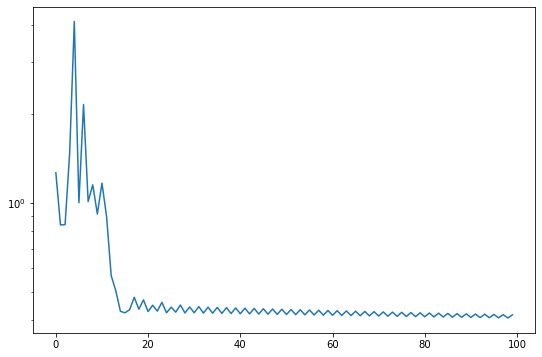

In [41]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [42]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.19806475, -0.04990224, -0.12762642,  0.20875122,  0.05930121,
         0.03536917,  0.21926376,  0.19467221, -0.19195611],
       [ 0.23030232,  0.11563407, -0.19635294,  0.04378898, -0.0902411 ,
        -0.01951182, -0.12302317,  0.06648196,  0.07925929],
       [ 0.02960814, -0.13346133,  0.22422465,  0.17859986,  0.04548482,
         0.02590851,  0.22263966, -0.15190757, -0.00123477],
       [ 0.20375408,  0.04099168,  0.09365372, -0.09976037, -0.06725888,
        -0.19475643, -0.11019337, -0.02333625,  0.10628234],
       [-0.0240236 , -0.0887783 , -0.09132052, -0.0157549 , -0.01704069,
        -0.15208747,  0.23184058, -0.07089196, -0.00501271],
       [-0.00148039, -0.0280581 , -0.10583121,  0.0053729 , -0.12534139,
         0.0534256 , -0.01288496, -0.2221086 ,  0.19704999],
       [ 0.05461699,  0.01342902, -0.05376131, -0.15366233,  0.14010246,
        -0.01082309, -0.15958898, -0.14747063,  0.09340736],
       [-0.06235989,  0.03217761, -0.0408

New Average Error with optimized weights:
 0.5333621590687682
Input:  [[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]
Output:  [[0.51747859 0.19280952 0.06583154 0.06955747 0.06674148 0.0875814 ]
 [0.50062859 0.20643878 0.06399292 0.07377848 0.06329647 0.09186476]
 [0.51144554 0.20165201 0.06378693 0.07365927 0.06181678 0.08763946]
 ...
 [0.47406117 0.17404863 0.0645253  0.12157078 0.04300808 0.12278603]
 [0.47358752 0.17623014 0.06458588 0.12021215 0.0431095  0.12227481]
 [0.47749201 0.17342283 0.06523812 0.11971492 0.04263385 0.12149828]]
Expected Output:  [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 

In [43]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.011020050057322123
0.00015235308247652302

Layer :  2
0.008203757691960592
0.00047899760231820117

Layer :  3
0.008529047516782157
0.00013659213


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [44]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs_train, outputs_train, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/100 [00:00<?, ?it/s]

Average Error with initial weights and biases: 1.2623581357943046
CPU times: user 362 ms, sys: 9.83 ms, total: 372 ms
Wall time: 368 ms


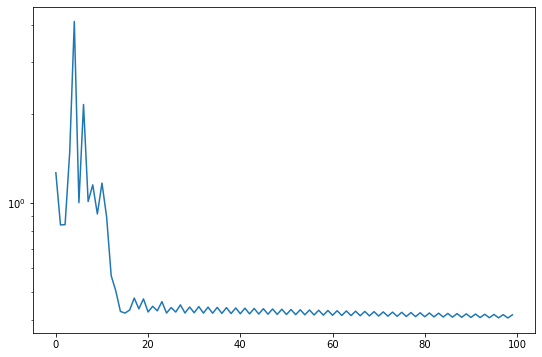

In [45]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

## Prediction on test set

In [46]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_test, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs_test)/batchSize)
print('Input: ',inputs_test)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs_test)

Optimized Weights:  [array([[ 0.1980648 , -0.04990162, -0.12762654,  0.20875115,  0.05930405,
         0.03536907,  0.21926431,  0.19467205, -0.19195609],
       [ 0.23030232,  0.11563407, -0.19635294,  0.04378898, -0.0902411 ,
        -0.01951182, -0.12302317,  0.06648196,  0.07925929],
       [ 0.02960819, -0.13346103,  0.22422507,  0.17859979,  0.04548719,
         0.02590861,  0.22263991, -0.15190764, -0.00123478],
       [ 0.20375408,  0.04099168,  0.09365372, -0.09976037, -0.06725888,
        -0.19475643, -0.11019337, -0.02333625,  0.10628234],
       [-0.02402356, -0.08877795, -0.09132051, -0.01575488, -0.01703873,
        -0.15208746,  0.23184093, -0.07089196, -0.00501271],
       [-0.00148039, -0.0280581 , -0.10583121,  0.0053729 , -0.12534139,
         0.0534256 , -0.01288496, -0.2221086 ,  0.19704999],
       [ 0.05461702,  0.01342907, -0.05376117, -0.15366251,  0.14010443,
        -0.01082354, -0.15958833, -0.14747088,  0.09340736],
       [-0.0623598 ,  0.03217834, -0.0408

In [47]:
# make probability predictions with the model
predictionsCrysx = a[nLayers]
print(predictionsCrysx) # Probabilities

predictions_max_int = (predictionsCrysx == predictionsCrysx.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[0.517661   0.20638657 0.0659603  0.06881153 0.06040531 0.08077529]
 [0.50526601 0.20136688 0.06840808 0.06939978 0.06221129 0.09334795]
 [0.50417408 0.20876027 0.06761181 0.06854098 0.06148226 0.0894306 ]
 [0.51463528 0.20849426 0.06875261 0.06568263 0.06068181 0.0817534 ]
 [0.49447301 0.20217359 0.0688731  0.07018413 0.06489298 0.0994032 ]
 [0.50330444 0.2103866  0.07001184 0.06886827 0.05992168 0.08750717]
 [0.5188047  0.20791071 0.0723197  0.06710803 0.05656591 0.07729094]
 [0.51566709 0.20812823 0.06813542 0.06622285 0.06075278 0.08109364]
 [0.51148679 0.20160724 0.06378477 0.07367027 0.06182478 0.08762615]
 [0.50149382 0.21234295 0.06638365 0.06985364 0.06228558 0.08764036]
 [0.50423986 0.20902724 0.06695923 0.07032138 0.06162115 0.08783115]
 [0.5087604  0.20919079 0.07275123 0.0706736  0.05508891 0.08353507]
 [0.50383132 0.21203418 0.07162662 0.06564987 0.06104266 0.08581535]
 [0.51246822 0.20917862 0.06589671 0.0685087  0.06110086 0.08284688]
 [0.5091086  0.205348   0.0661914 

In [48]:
# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[13,  0,  0,  0,  0,  0],
       [24,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0],
       [ 6,  0,  0,  0,  0,  0]])

In [49]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.011016340432724286
0.00015230140201749284

Layer :  2
0.008202871262982588
0.0004789395062763832

Layer :  3
0.008529069303621545
0.00013655031


### BCE testing

In [50]:
X = torch.tensor([[1,0],[1,0],[0,1],[0,1]],dtype=torch.float)
softmaxTorch = torch.nn.Softmax(dim=1)


bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
ce_loss= torch.nn.CrossEntropyLoss()

# My implementation of Softmax
pred = Softmax(X.cpu().detach().numpy())
print(pred)
# PyTorch implementation of Softmax
pred = softmaxTorch(X)
print(pred)


print(bce_loss(X,X)) # tensor(0.)
print(bce_loss(pred,X)) # tensor(0.3133)
print(bce_loss(pred,pred)) # tensor(0.5822)

print(ce_loss(X,torch.argmax(X,dim=1))) # tensor(0.3133)

# My implementation of cross entropy loss
# Note these will be Nsamples*PyTorch results as I don't return the average right away
print(binary_cross_entropy(X.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(binary_cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(binary_cross_entropy(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())/X.shape[0])

print(binary_cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(errorFuncGrad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])

predX = torch.tensor(pred,dtype=torch.float,requires_grad=True)
loss = bce_loss(predX,X)
# loss = ce_loss(predX,torch.argmax(X,dim=1))
# loss = mse_loss(predX,X)
loss.backward()
print('gradient',predX.grad)
print(torch.autograd.grad(bce_loss(predX,X),predX))

%timeit binary_cross_entropy(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())
%timeit binary_cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())
%timeit bce_loss(predX,X)

%timeit softmaxTorch(X)
%timeit Softmax(X.cpu().detach().numpy())

%timeit cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]
%timeit cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]

[[0.7310586  0.26894143]
 [0.7310586  0.26894143]
 [0.26894143 0.7310586 ]
 [0.26894143 0.7310586 ]]
tensor([[0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.2689, 0.7311],
        [0.2689, 0.7311]])
tensor(0.)
tensor(0.3133)
tensor(0.5822)
tensor(0.3133)
-4.991562718714704e-13
0.3132616819994708
0.5822031048526861
0.3132616819994708
[[-0.34196985 -0.        ]
 [-0.34196985 -0.        ]
 [-0.         -0.34196985]
 [-0.         -0.34196985]]
[[-0.06723535  0.06723536]
 [-0.06723535  0.06723536]
 [ 0.06723536 -0.06723535]
 [ 0.06723536 -0.06723535]]
gradient tensor([[-0.1710,  0.1710],
        [-0.1710,  0.1710],
        [ 0.1710, -0.1710],
        [ 0.1710, -0.1710]])
(tensor([[-0.1710,  0.1710],
        [-0.1710,  0.1710],
        [ 0.1710, -0.1710],
        [ 0.1710, -0.1710]]),)


/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


149 µs ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.8 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
33.6 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.19 µs ± 98.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.95 µs ± 24.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
120 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.2 µs ± 356 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### ReLU testing

In [51]:
device = 'cpu'

X = torch.randn((1000,300),requires_grad=True)

actFunc = torch.nn.ReLU()
# actFunc = torch.nn.Sigmoid()
activatedOutputs = actFunc(X)
print(activatedOutputs)
print(ReLU(X.cpu().detach().numpy()))
# print(Sigmoid(X.cpu().detach().numpy()))

print('Difference CrysX and pytorch values of relu')
print(abs(activatedOutputs.cpu().detach().numpy() - ReLU(X.cpu().detach().numpy())).max())


gradientsTorch = torch.autograd.grad(outputs=activatedOutputs, inputs=X,
                          grad_outputs=torch.ones(activatedOutputs.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

print(gradientsTorch)

# gradientsCrysx = Sigmoid_grad(X.cpu().detach().numpy())
gradientsCrysx = ReLU_grad(X.cpu().detach().numpy())
print(gradientsCrysx)

print('Difference CrysX and pytorch gradients of relu')
print(abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())

tensor([[0.1003, 0.0000, 1.0158,  ..., 1.2276, 0.0000, 0.0000],
        [0.8316, 0.5142, 0.4733,  ..., 0.0000, 1.1672, 1.3277],
        [0.0000, 1.2682, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0764, 0.0414, 1.0552,  ..., 0.0000, 0.0000, 0.1531],
        [0.3652, 0.6781, 1.1334,  ..., 0.3085, 0.6906, 0.7115],
        [0.0000, 0.0000, 2.3803,  ..., 0.0000, 0.2545, 0.0000]],
       grad_fn=<ReluBackward0>)
[[0.10029476 0.         1.01583946 ... 1.22764874 0.         0.        ]
 [0.83160734 0.51423895 0.47331145 ... 0.         1.16717982 1.32767451]
 [0.         1.26816165 0.         ... 0.         0.         0.        ]
 ...
 [1.07640541 0.04139405 1.0552485  ... 0.         0.         0.15306124]
 [0.36520794 0.67808777 1.13341188 ... 0.30846781 0.69064677 0.71149606]
 [0.         0.         2.3803165  ... 0.         0.25447649 0.        ]]
Difference CrysX and pytorch values of relu
0.0
tensor([[1., 0., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.]

# PyTorch

In [52]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [53]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [54]:
Network = torch.nn.Sequential(*Layers)

In [55]:
print(Network)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=6, bias=True)
  (5): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [56]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [57]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (act0): ReLU()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): ReLU()
  (2): Linear(in_features=100, out_features=6, bias=True)
  (act2): Softmax(dim=1)
)

## initial weights and biases generated by Pytorch

In [58]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[ 2.7709e-01,  8.6935e-02, -4.0877e-02, -3.1137e-01,  2.6580e-01,
          3.2196e-01, -1.5511e-01, -7.3904e-02,  2.4712e-01],
        [ 2.6218e-01,  1.5133e-01,  1.5451e-01,  2.3109e-01, -1.2287e-01,
         -6.7003e-02, -2.3599e-01, -5.0884e-02, -2.4442e-01],
        [-6.4319e-02, -9.5937e-04, -4.9110e-02,  1.7373e-01, -1.7545e-01,
         -1.4400e-01, -4.6761e-02,  3.1619e-01,  2.7241e-01],
        [-3.2695e-01,  2.9507e-01,  2.3114e-01,  1.5242e-01, -1.8660e-01,
          1.9696e-01,  1.9038e-01, -1.3720e-01, -1.4572e-01],
        [ 3.1522e-01,  1.6802e-01, -8.3762e-02, -2.2128e-01,  5.9100e-02,
         -1.2665e-01,  3.0555e-01,  6.3607e-02, -2.5805e-01],
        [ 1.0641e-02,  1.3043e-01, -1.3859e-01,  6.1426e-02,  6.6761e-02,
          1.8447e-01,  2.5427e-01, -1.7565e-01,  2.4918e-01],
        [-1.7025e-01, -5.0188e-02, -3.3075e-01, -1.6729e-01,  2.9615e-01,
          1.2524e-01, -1.5957e-01, -2.7569e-01,  8.9669e-02],
        [-1.6071e-01,  1.7

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [59]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [60]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 1.9859e-01, -4.6493e-02, -1.2844e-01,  2.0986e-01,  8.4003e-02,
          3.6929e-02,  2.2449e-01,  1.9397e-01, -1.9188e-01],
        [ 2.3030e-01,  1.1563e-01, -1.9635e-01,  4.3789e-02, -9.0241e-02,
         -1.9512e-02, -1.2302e-01,  6.6482e-02,  7.9259e-02],
        [ 2.9843e-02, -1.3056e-01,  2.1898e-01,  1.8111e-01,  5.6824e-02,
          2.6979e-02,  2.2385e-01, -1.5008e-01, -1.2313e-03],
        [ 2.0375e-01,  4.0992e-02,  9.3654e-02, -9.9760e-02, -6.7259e-02,
         -1.9476e-01, -1.1019e-01, -2.3336e-02,  1.0628e-01],
        [-2.4096e-02, -8.9186e-02, -9.1249e-02, -1.5736e-02, -2.0152e-02,
         -1.5207e-01,  2.3064e-01, -7.0892e-02, -5.0310e-03],
        [-1.4804e-03, -2.8058e-02, -1.0583e-01,  5.3729e-03, -1.2534e-01,
          5.3426e-02, -1.2885e-02, -2.2211e-01,  1.9705e-01],
        [ 5.5076e-02,  1.7930e-02, -4.9971e-02, -1.5466e-01,  1.6199e-01,
         -1.0932e-02, -1.5747e-01, -1.4821e-01,  9.3268e-02],
        [-6.2007e-02,  3.5762e-02, -4.

In [61]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.MSELoss()
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (act0): ReLU()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): ReLU()
  (2): Linear(in_features=100, out_features=6, bias=True)
  (act2): Softmax(dim=1)
)
11706 trainable parameters


In [62]:
inputsTorch = torch.from_numpy(inputs_train)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs_train)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [63]:
print(inputsTorch)
print(labels)

tensor([[1.5179e+00, 1.2790e+01, 3.5000e+00,  ..., 8.7700e+00, 0.0000e+00,
         0.0000e+00],
        [1.5190e+00, 1.3490e+01, 3.4800e+00,  ..., 9.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5183e+00, 1.3330e+01, 3.3400e+00,  ..., 8.9900e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.5176e+00, 1.2980e+01, 3.5400e+00,  ..., 8.5300e+00, 0.0000e+00,
         0.0000e+00],
        [1.5156e+00, 1.3870e+01, 0.0000e+00,  ..., 9.4100e+00, 8.1000e-01,
         1.0000e-02],
        [1.5212e+00, 1.2970e+01, 3.3000e-01,  ..., 1.1270e+01, 0.0000e+00,
         2.8000e-01]])
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0

In [64]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs+1)
errorPlot = []
nBatches = int(inputsTorch.shape[0]/batchSize)
print(nBatches)
### Train the model
for e in tqdm(epochs,miniters=100):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
#     for iBatch in tqdm(range(nBatches),leave=False,miniters=100):
    for iBatch in range(nBatches):
        offset = iBatch*batchSize
        inputsBatch = inputsTorch[offset:offset + batchSize,:]# Input vector
#            print(x.shape)
        labelsBatch = labels[offset:offset + batchSize,:] # Expected output
#         print(inputsBatch.shape)
        
        opt.zero_grad() # zero gradient values
        inputsBatch = inputsBatch.to(device=device) # move input and label tensors to the device with the model
        labelsBatch = labelsBatch.to(device=device)
        outputsTorch = Network(inputsBatch) # compute model outputs
        loss = crit(outputsTorch, labelsBatch) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputsBatch) # add the batch loss to the running loss
        samples += len(inputsBatch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
    print(e, tr_loss)

1


  0%|          | 0/100 [00:00<?, ?it/s]

1 1.2623579502105713
2 0.8413865566253662
3 0.8432416915893555
4 1.478617787361145
5 4.09867000579834
6 0.9960343241691589
7 2.1283204555511475
8 0.9577395915985107
9 1.1794315576553345
10 0.9143753051757812
11 1.3172504901885986
12 0.8910203576087952
13 0.9833929538726807
14 0.6177396178245544
15 0.6053779125213623
16 0.6452223658561707
17 0.5765047669410706
18 0.5273236632347107
19 0.5356598496437073
20 0.5611972212791443
21 0.4931224286556244
22 0.5344727635383606
23 0.5475773811340332
24 0.5712845921516418
25 0.467838317155838
26 0.4469691514968872
27 0.4189337193965912
28 0.41493454575538635
29 0.41879794001579285
30 0.418012410402298
31 0.4339146614074707
32 0.41938337683677673
33 0.43561479449272156
34 0.4181535840034485
35 0.4331533908843994
36 0.4174180328845978
37 0.4316946566104889
38 0.41743534803390503
39 0.4321288466453552
40 0.4164975881576538
41 0.43005263805389404
42 0.41635051369667053
43 0.43012094497680664
44 0.4156532883644104
45 0.4286532998085022
46 0.41550645232

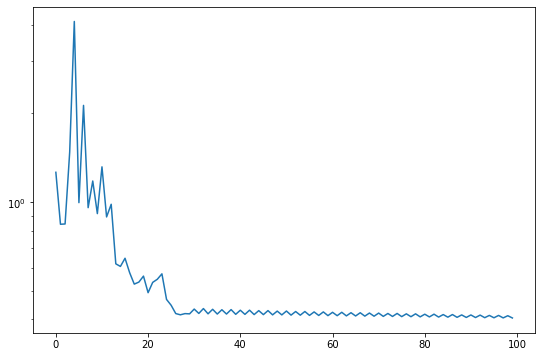

In [65]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [66]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(0.0097)
tensor(0.0001)

Layer :  2
tensor(0.0070)
tensor(0.0004)

Layer :  3
tensor(0.0049)
tensor(0.0003)


## Predictions on the test set

In [67]:
# make probability predictions with the model
predictionsTorch = Network(torch.from_numpy(inputs_test)).detach().numpy()
print(predictionsTorch) # Probabilities

predictions_max_int = (predictionsTorch == predictionsTorch.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[0.18379098 0.42679527 0.10401904 0.05914555 0.04908371 0.17716555]
 [0.18362866 0.38470387 0.10907225 0.05634318 0.05647296 0.20977902]
 [0.17971547 0.4108474  0.10692769 0.0561836  0.05194199 0.19438395]
 [0.18468419 0.41949344 0.10902163 0.05529791 0.05118961 0.18031318]
 [0.17970529 0.3730932  0.10870756 0.05571187 0.06023993 0.22254209]
 [0.17845243 0.4120994  0.11016191 0.05640206 0.05102036 0.19186391]
 [0.1856857  0.4215084  0.11461212 0.05700752 0.04806577 0.17312047]
 [0.18426894 0.42262924 0.10833451 0.055867   0.05060926 0.1782911 ]
 [0.18196622 0.41126028 0.10109868 0.06237862 0.0510302  0.19226603]
 [0.17607404 0.4225813  0.1036821  0.0577784  0.05098969 0.18889445]
 [0.17821504 0.41527376 0.10588329 0.05787433 0.05146942 0.19128416]
 [0.18062772 0.40707415 0.11526749 0.05788608 0.04913486 0.19000964]
 [0.1807807  0.41012847 0.11157744 0.05426977 0.05316693 0.19007657]
 [0.1812025  0.42731562 0.10333231 0.05824791 0.04958954 0.18031219]
 [0.18242517 0.41262746 0.10468756

In [68]:
# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[ 0, 13,  0,  0,  0,  0],
       [ 0, 24,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0]])